Checking required packages...
Please select the data folder window...
Selected Directory: D:/python_workplace/ESP32_ autonomous_driving/20251207_16_37_42
Original data count: 189
Filtered data count (removed backward): 156
Loading images and syncing labels...


 29%|███████████████████████                                                         | 45/156 [00:00<00:00, 442.26it/s]

File missing: _4_backward\20251207_16_38_01_470427.png


100%|███████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 425.45it/s]

Final loaded tensors shape: (155, 120, 160, 3)
Final loaded targets shape: (155,)


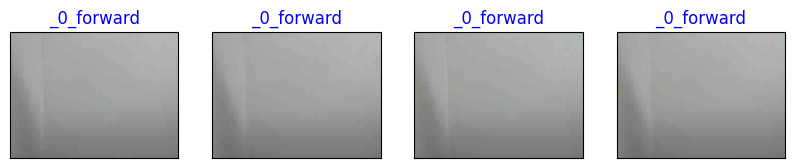

Train shapes: (124, 120, 160, 3), (124, 4)
Test shapes: (16, 120, 160, 3), (16, 4)
Valid shapes: (15, 120, 160, 3), (15, 4)
Epoch 1/20
4/4 [==============================] - 1s 111ms/step - loss: 1.3946 - accuracy: 0.2984 - val_loss: 1.4264 - val_accuracy: 0.0000e+00
Epoch 2/20
4/4 [==============================] - 0s 84ms/step - loss: 1.3831 - accuracy: 0.2903 - val_loss: 1.4293 - val_accuracy: 0.0000e+00
Epoch 3/20
4/4 [==============================] - 0s 81ms/step - loss: 1.3836 - accuracy: 0.2823 - val_loss: 1.4269 - val_accuracy: 0.0000e+00
Epoch 4/20
4/4 [==============================] - 0s 82ms/step - loss: 1.3750 - accuracy: 0.2581 - val_loss: 1.4359 - val_accuracy: 0.0000e+00
Epoch 5/20
4/4 [==============================] - 0s 84ms/step - loss: 1.3697 - accuracy: 0.2903 - val_loss: 1.4697 - val_accuracy: 0.0000e+00
Epoch 6/20
4/4 [==============================] - 0s 86ms/step - loss: 1.3669 - accuracy: 0.2258 - val_loss: 1.4780 - val_accuracy: 0.0000e+00
Epoch 7/20
4/4 [=

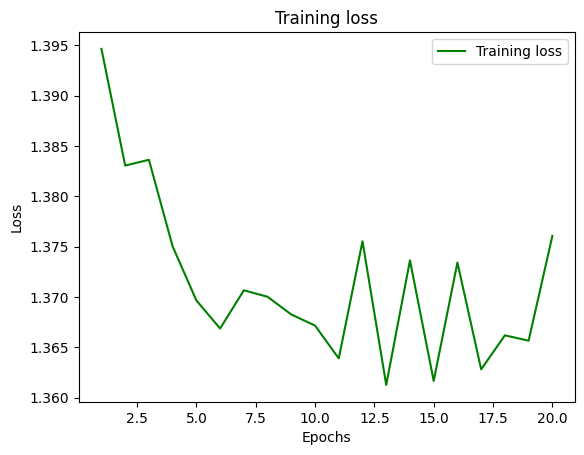

Model saved to model.h5
Evaluating model...
1/1 [==============================] - 0s 50ms/step


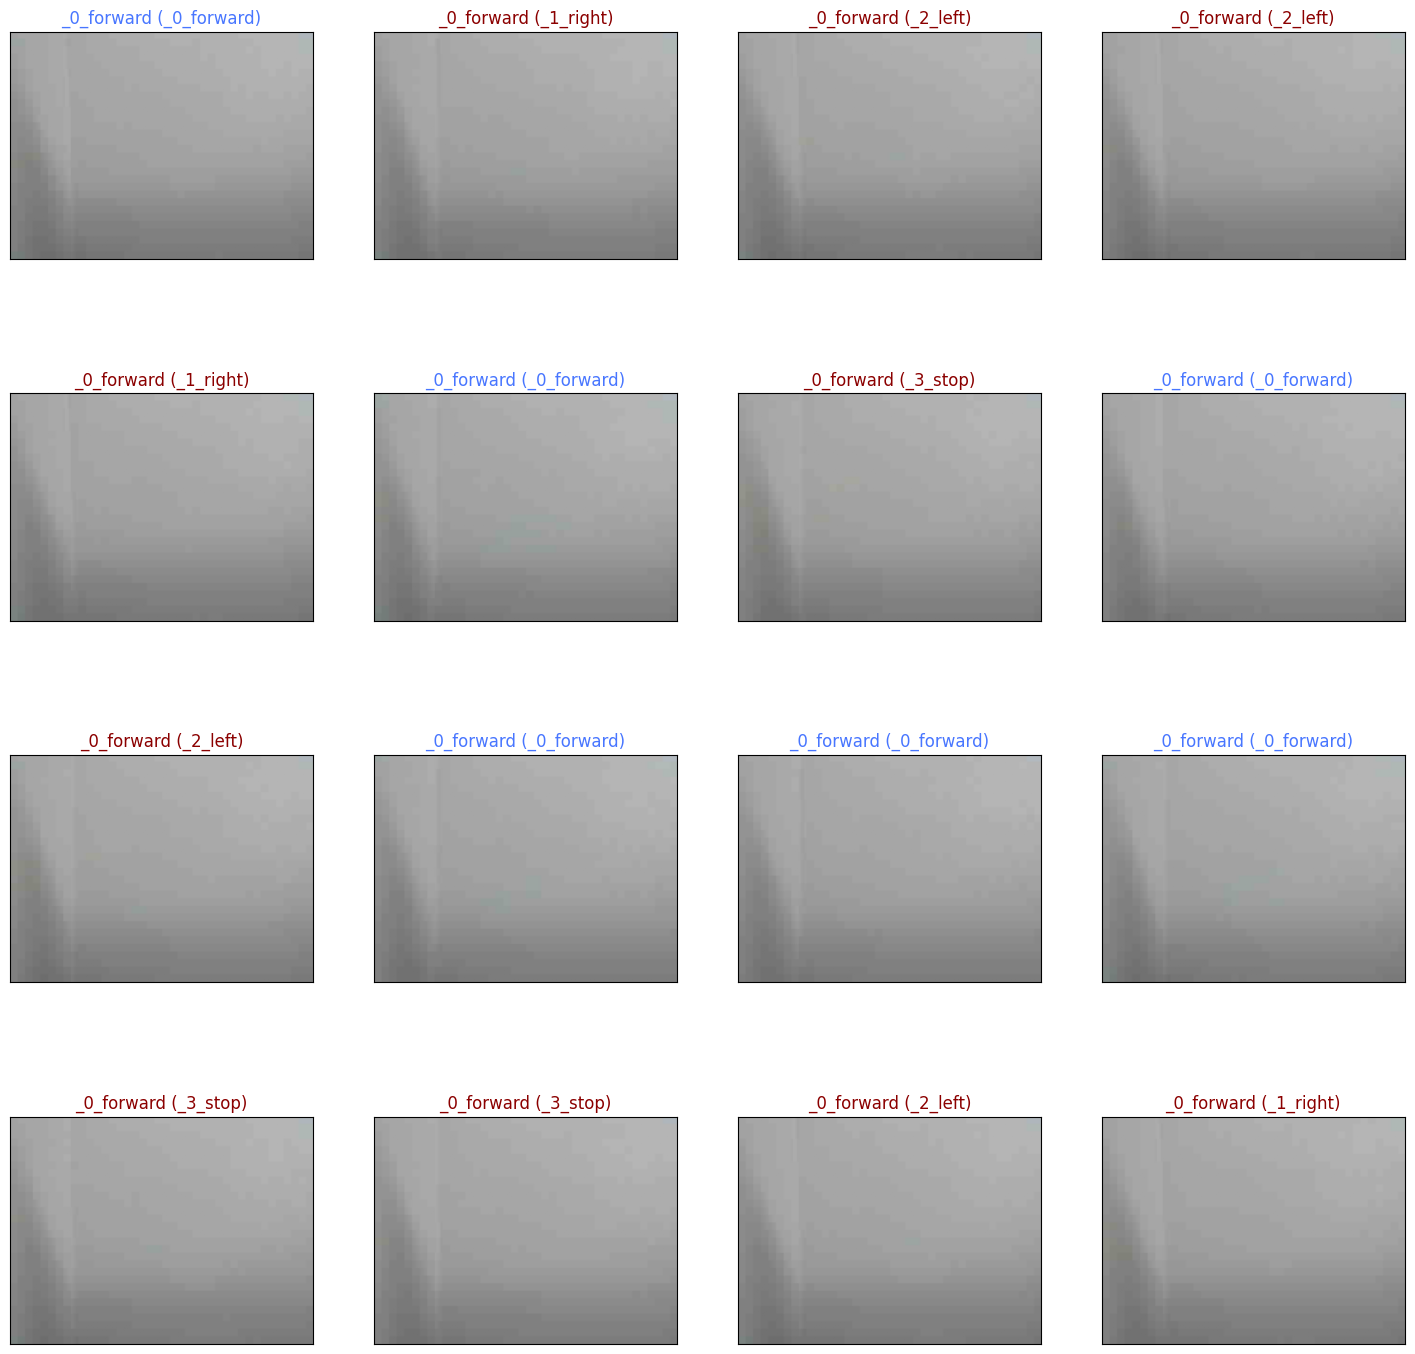

In [9]:
import sys
import subprocess
import importlib
import os
import tkinter as tk
from tkinter import filedialog

# ---------------------------------------------------------
# 1. 패키지 자동 설치 함수
# ---------------------------------------------------------
def install_package(module_name, package_name=None):
    if package_name is None:
        package_name = module_name
    try:
        importlib.import_module(module_name)
    except ImportError:
        print(f"Installing {package_name} ...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            print(f"{package_name} installation completed")
        except subprocess.CalledProcessError as e:
            print(f"{package_name} installation failed (exit code {e.returncode})")
            sys.exit(1)

# 필수 패키지 확인 및 설치
print("Checking required packages...")
install_package("tensorflow")
install_package("numpy")
install_package("pandas")
install_package("tqdm")
install_package("PIL", "Pillow")
install_package("cv2", "opencv-python")
install_package("matplotlib")
install_package("sklearn", "scikit-learn")

# ---------------------------------------------------------
# 2. 라이브러리 임포트
# ---------------------------------------------------------
from tensorflow.keras.preprocessing import image as keras_image
import numpy as np
from tqdm import tqdm
from PIL import ImageFile
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import load_model

# ---------------------------------------------------------
# 3. 데이터 로드 및 전처리 (수정됨: 폴더 선택 기능)
# ---------------------------------------------------------

print("Please select the data folder window...")
root = tk.Tk()
root.withdraw() # TK 창 숨기기
dirname = filedialog.askdirectory(title='Select Data Folder to Train') # 폴더 선택 창 띄우기
root.destroy()

if not dirname:
    print("No folder selected. Exiting...")
    sys.exit()

print(f"Selected Directory: {dirname}")

# 경로 보정
if not dirname.endswith('/'):
    dirname += '/'

def image_to_tensor(img_path):
    try:
        path = os.path.join(dirname, img_path)
        # 파일 존재 여부 먼저 확인
        if not os.path.exists(path):
            print(f"File missing: {img_path}")
            return None
            
        img = keras_image.load_img(path, target_size=(120,160))
        x = keras_image.img_to_array(img)
        return np.expand_dims(x, axis=0)
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return None

ImageFile.LOAD_TRUNCATED_IMAGES = True

# CSV 로드
csv_path = os.path.join(dirname, "0_road_labels.csv")
if not os.path.exists(csv_path):
    print(f"Error: CSV file '{csv_path}' not found in the selected folder.")
    sys.exit()

data = pd.read_csv(csv_path)

# [중요] 후진 데이터(Label 4) 제거 로직
print(f"Original data count: {len(data)}")
data = data[data['label'] != 4] # 라벨 4가 아닌 것만 남김
print(f"Filtered data count (removed backward): {len(data)}")

# 인덱스 초기화
data = data.reset_index(drop=True)

print("Loading images and syncing labels...")

# [수정된 로직] 이미지와 라벨을 동시에 리스트에 담으면서, 
# 이미지가 없는 경우 라벨도 같이 버립니다.
valid_tensors = []
valid_labels = []

for index, row in tqdm(data.iterrows(), total=data.shape[0]):
    img_path = row['file']
    label = row['label']
    
    tensor = image_to_tensor(img_path)
    
    if tensor is not None:
        valid_tensors.append(tensor)
        valid_labels.append(label)

# 리스트를 numpy 배열로 변환
if len(valid_tensors) > 0:
    tensors = np.vstack(valid_tensors)
    targets = np.array(valid_labels)
else:
    print("Error: No valid images loaded.")
    sys.exit()

# 확인용 파일 리스트 업데이트 (시각화를 위해)
files = data['file'].values[:len(targets)] 

print(f"Final loaded tensors shape: {tensors.shape}")
print(f"Final loaded targets shape: {targets.shape}")

# 개수가 맞지 않으면 강제 종료 (안전장치)
if tensors.shape[0] != targets.shape[0]:
    print("Error: Mismatch between images and labels.")
    sys.exit()
# ---------------------------------------------------------
# 4. 데이터 시각화 (확인용)
# ---------------------------------------------------------
names = ['_0_forward', '_1_right', '_2_left', '_3_stop']

def display_images(img_path, ax):
    img = cv2.imread(os.path.join(dirname, img_path))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

fig = plt.figure(figsize=(10, 3))
count = 0
for i in range(len(files)):
    if count >= 4: break
    # 랜덤하게 몇 개만 보여주기 위해 앞부분 사용
    ax = fig.add_subplot(1, 4, count + 1, xticks=[], yticks=[])
    ax.set_title(names[targets[i]], color='blue')
    display_images(files[i], ax)
    count += 1
plt.show()

# ---------------------------------------------------------
# 5. 데이터셋 분리 (Train / Test / Validation)
# ---------------------------------------------------------
tensors = tensors.reshape(-1,120,160,3)

# 정규화 (0~255 -> 0~1)
tensors = tensors.astype('float32')/255

# 원-핫 인코딩 (4개 클래스: 0,1,2,3)
targets = to_categorical(targets, 4)

x_train, x_test, y_train, y_test = train_test_split(
        tensors,
        targets,
        test_size = 0.2,
        random_state = 1)

n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]

print(f"Train shapes: {x_train.shape}, {y_train.shape}")
print(f"Test shapes: {x_test.shape}, {y_test.shape}")
print(f"Valid shapes: {x_valid.shape}, {y_valid.shape}")

# ---------------------------------------------------------
# 6. 모델 정의 (CNN) - 기존 유지
# ---------------------------------------------------------
model = tf.keras.Sequential([ # donkey car CNN style
    tf.keras.layers.Conv2D(24, (5, 5), strides=(2, 2), padding="same",
        activation='relu', input_shape=x_train.shape[1:]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding="same",
        activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same",
        activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(50,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4,activation='softmax') # 4개 클래스 유지
])

model.compile(loss='categorical_crossentropy',
        optimizer='adam', metrics=['accuracy'])

# ---------------------------------------------------------
# 7. 학습 실행
# ---------------------------------------------------------
# epochs는 필요에 따라 조절하세요 (기존 40)
history = model.fit(x_train, y_train, epochs=20, 
        validation_data=(x_valid, y_valid))

loss = history.history['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 모델 저장
model.save("model.h5")
print("Model saved to model.h5")

# ---------------------------------------------------------
# 8. 테스트 및 검증
# ---------------------------------------------------------
print("Evaluating model...")
model1 = load_model('model.h5')

y_test_predict = model1.predict(x_test)
y_test_predict = np.argmax(y_test_predict,axis=1)

# 테스트 데이터 시각화
sample_size = min(16, x_test.shape[0])
if sample_size > 0:
    fig = plt.figure(figsize=(18, 18))
    # 랜덤 샘플링
    indices = np.random.choice(x_test.shape[0], size=sample_size, replace=False)
    for i, idx in enumerate(indices):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(x_test[idx]))
        pred_idx = y_test_predict[idx]
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(names[pred_idx], names[true_idx]),
            color=("#4876ff" if pred_idx == true_idx else "darkred"))
    plt.show()
else:
    print("Not enough test data to visualize.")